# Анализ вакансий для IT-специалистов с использованием API HeadHunter

Этот скрипт предназначен для сбора и анализа данных о вакансиях для IT-специалистов с сайта HeadHunter. Он фокусируется на направлениях Data Analyst, Data Science и Data Engineer, а также рассматривает уровни квалификации (Junior, Middle, Senior) для регионов Санкт-Петербург и Москва.

## Основные этапы работы скрипта

1. **Получение ID региона**:
   - Используется функция `get_region_id(region_name)`, которая возвращает уникальный идентификатор региона, необходимый для запросов к API.

2. **Сбор данных о вакансиях**:
   - Для каждого региона, позиции и уровня производится запрос к API HeadHunter.
   - Извлекается информация о вакансиях, включая название, работодателя, регион и дату публикации.

3. **Преобразование и сортировка данных**:
   - Данные преобразуются в DataFrame с использованием Pandas.
   - Даты публикации вакансий преобразуются в формат datetime для удобства анализа.

4. **Анализ и визуализация данных**:
   - **Линейный график**: Отображает количество публикаций вакансий по времени.
   - **Тепловая карта**: Показывает распределение количества вакансий по направлениям и уровням.
   - **Диаграмма по дням недели**: Анализирует количество вакансий, опубликованных в разные дни недели.
   - **Круговая диаграмма**: Визуализирует распределение вакансий среди топ-10 работодателей для каждого региона.

## Результаты

- **Линейный график** Видим, что в начале месяца вакансии размещаются активнее, а дальше примерно одинаковым образом. 
- **Тепловая карта** Кажется, начинающим саентистам не очень везёт((
- **Диаграмма по дням недели** Всё логично, понедельник
- **Круговая диаграмма** Просто интересно посмотреть, какие айти-компании в топе в двух столицах.


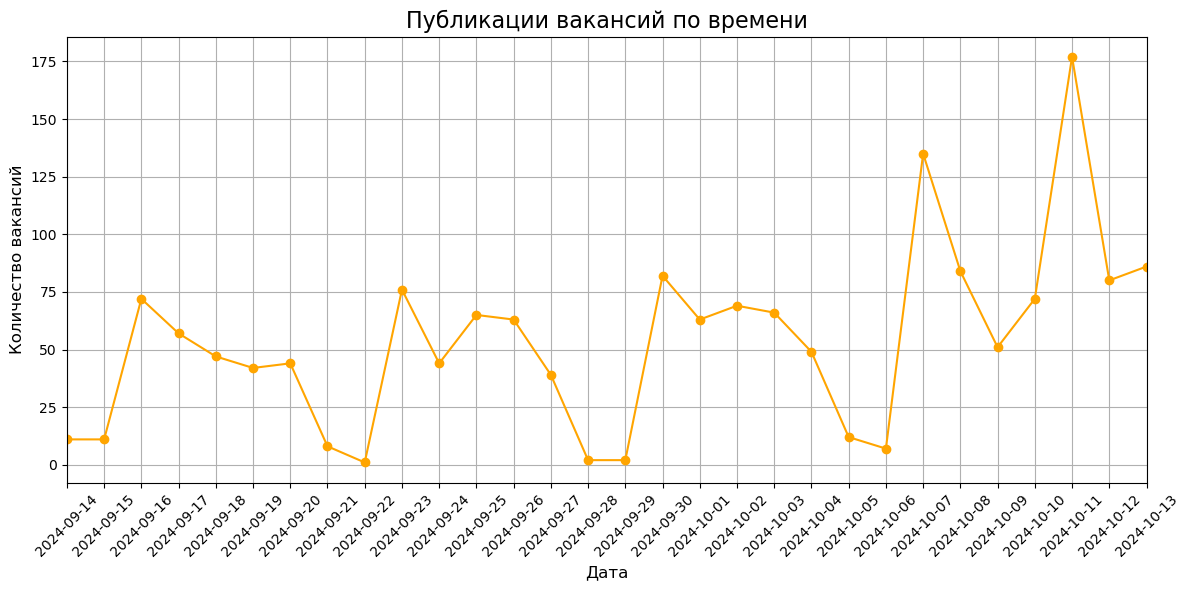

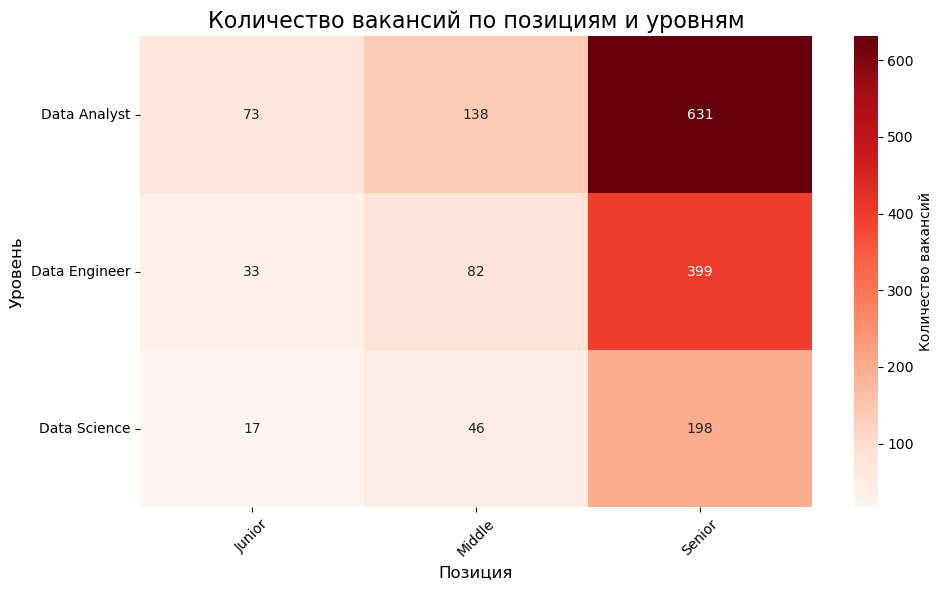

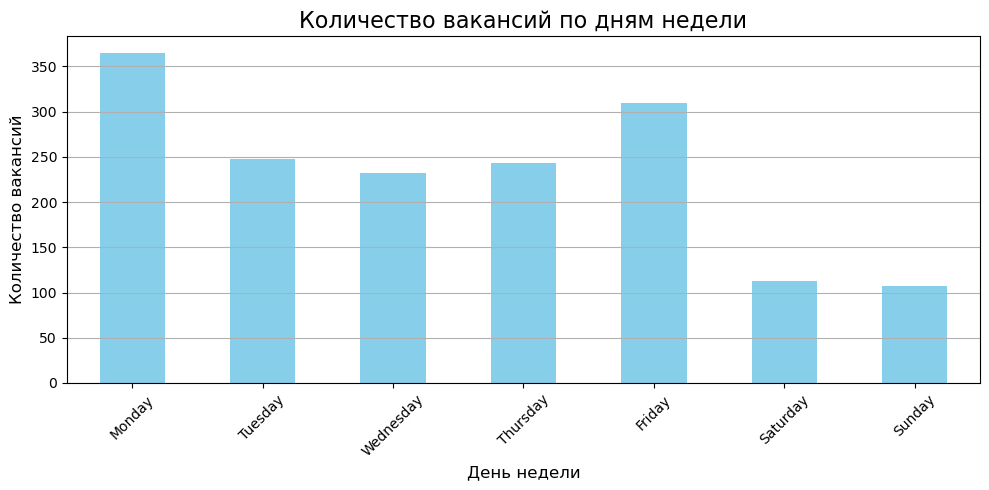

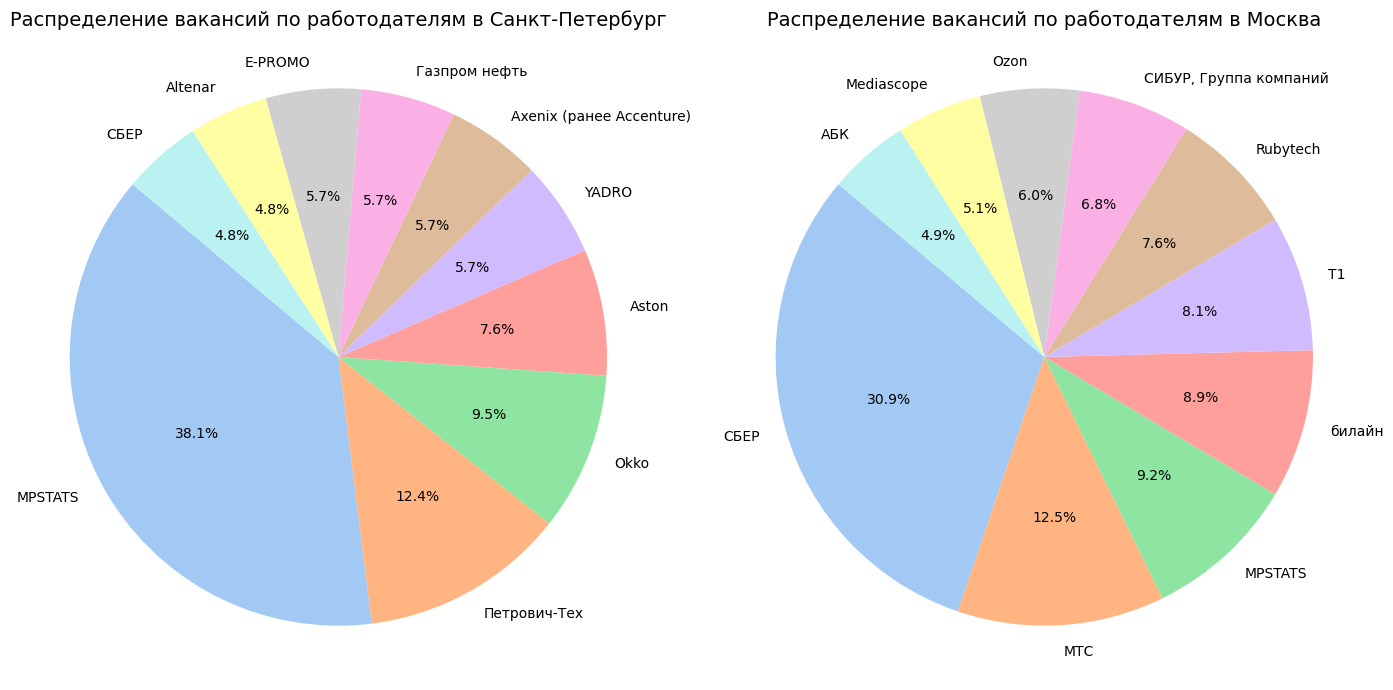

In [4]:
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Параметры поиска
regions = ['Санкт-Петербург', 'Москва']
positions = ['Data Analyst', 'Data Science', 'Data Engineer']
levels = ['Junior', 'Middle', 'Senior']

base_url = "https://api.hh.ru/vacancies"

results = []

def get_region_id(region_name):
    """Получить ID региона по названию."""
    region_url = "https://api.hh.ru/areas"
    response = requests.get(region_url)
    areas = response.json()
    
    # Поиск ID региона
    for area in areas:
        if area['name'] == region_name:
            return area['id']
        for sub_area in area.get('areas', []):
            if sub_area['name'] == region_name:
                return sub_area['id']
    return None

for region in regions:
    region_id = get_region_id(region)
    if region_id is None:
        print(f"Регион '{region}' не найден.")
        continue

    for position in positions:
        for level in levels:
            search_params = {
                'text': f"{position} {level}",
                'area': region_id,
                'per_page': 100,
                'page': 0,
            }

            while True:
                response = requests.get(base_url, params=search_params)
                data = response.json()

                vacancies = data.get('items', [])
                if not vacancies:
                    break

                for vacancy in vacancies:
                    title = vacancy['name']
                    employer = vacancy['employer']['name'] if vacancy['employer'] else "Не указано"
                    posting_date = vacancy['published_at'][:10]

                    results.append({
                        'направление': position,
                        'уровень': level,
                        'название вакансии': title,
                        'работодатель': employer,
                        'регион': region,
                        'дата публикации': posting_date
                    })

                if search_params['page'] < data['pages'] - 1:
                    search_params['page'] += 1
                else:
                    break

# Конвертация в DataFrame
df = pd.DataFrame(results)

# Преобразование столбца с датами в формат datetime и сортировка
df['дата публикации'] = pd.to_datetime(df['дата публикации'])
df = df.sort_values('дата публикации')

# 1. Линейный график публикаций вакансий по времени
vacancies_by_date = df.groupby('дата публикации').size()

plt.figure(figsize=(12, 6))
vacancies_by_date.plot(kind='line', marker='o', color='orange')
plt.title('Публикации вакансий по времени', fontsize=16)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Количество вакансий', fontsize=12)

# Форматирование оси X
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Тепловая карта количества вакансий
count_vacancies = df.groupby(['направление', 'уровень']).size().unstack(fill_value=0)

plt.figure(figsize=(10, 6))
sns.heatmap(count_vacancies, annot=True, fmt='d', cmap='Reds', cbar_kws={'label': 'Количество вакансий'})
plt.title('Количество вакансий по позициям и уровням', fontsize=16)
plt.xlabel('Позиция', fontsize=12)
plt.ylabel('Уровень', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 3. Диаграмма размещения вакансий по дням недели
df['день недели'] = df['дата публикации'].dt.day_name()
vacancies_by_weekday = df['день недели'].value_counts().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.figure(figsize=(10, 5))
vacancies_by_weekday.plot(kind='bar', color='skyblue')
plt.title('Количество вакансий по дням недели', fontsize=16)
plt.xlabel('День недели', fontsize=12)
plt.ylabel('Количество вакансий', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# 4. Круговая диаграмма по работодателям рядом друг с другом
fig, axes = plt.subplots(1, len(regions), figsize=(14, 7))

for ax, region in zip(axes, regions):
    region_df = df[df['регион'] == region]

    if not region_df.empty:
        employers_count = region_df['работодатель'].value_counts().head(10)

        ax.pie(employers_count, labels=employers_count.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("pastel"))
        ax.set_title(f'Распределение вакансий по работодателям в {region}', fontsize=14)
        ax.axis('equal')  # Для круговой диаграммы
    else:
        ax.set_title(f'Нет вакансий для региона {region}', fontsize=14)
        ax.axis('equal')  # Для круговой диаграммы

plt.tight_layout()
plt.show()